In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

import torch
from torch import nn

from utils import get_gaussian_targets
from models import RNN
from train import test, pre_train, train, train_simple, set_optimimal_w_out
from viz import plot_stability, plot_state_traj

In [2]:
# set meta-parameters
# for plotting style
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', rc=custom_params)
# for pytorch tensors
device = 'cpu'
# for reproducibility while troubleshooting; numpy is for model sparse conns
torch.random.manual_seed(93214)
np.random.seed(35107)

adjusted gain: 6.4


/home/ryan/time_coding/train.py:154: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Test loss: 0.468881
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
I

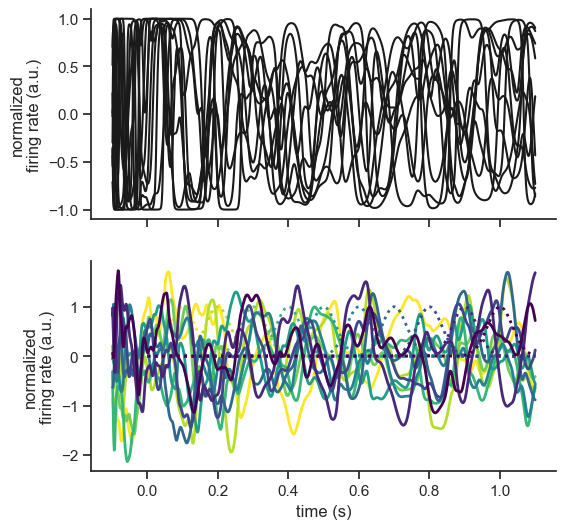

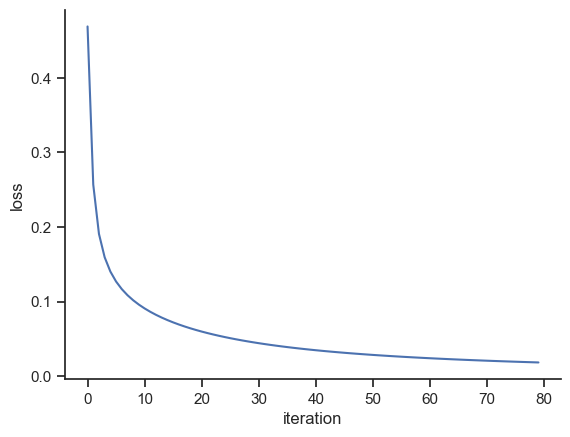

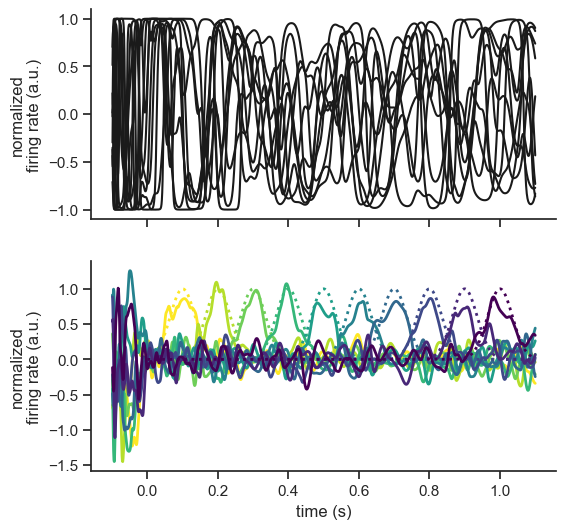

In [3]:
# instantiate model, loss function, and optimizer
n_inputs, n_hidden, n_outputs = 1, 300, 10
model = RNN(n_inputs=n_inputs, n_hidden=n_hidden,
            n_outputs=n_outputs, echo_state=False)
model.to(device)

loss_fn = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# set parameters
# simulation parameters
dt = 1e-3  # 1 ms
tstop = 1.1  # 1 sec
times = np.arange(-0.1 + dt, tstop + dt, dt)
n_times = len(times)

# define inputs (for contextual modulation / recurrent perturbations)
n_batches = 1
inputs = torch.zeros((n_batches, n_times, n_inputs))
perturb_dur = 0.05  # 50 ms
perturb_win_mask = np.logical_and(times > -perturb_dur, times < 0)
inputs[:, perturb_win_mask, :] = 1.0

# define output targets
# set std s.t. amplitude decays to 1/e at intersection with next target
targ_std = 0.05 / np.sqrt(2)  # ~35 ms
targets, delay_times_ = get_gaussian_targets(n_batches, n_outputs, times,
                                             targ_std)

# set initial conditions of recurrent units fixed across iterations of
# training and testing
h_0 = torch.rand(n_hidden) * 2 - 1  # uniform in (-1, 1)
h_0 = torch.tile(h_0, (n_batches, 1))  # replicate for each batch
r_0 = torch.rand(n_hidden) * model.p_rel.detach()  # uniform in (0, p_rel)
r_0 = torch.tile(r_0, (n_batches, 1))
u_0 = torch.rand(n_hidden) # uniform in (0, 1)
u_0 = torch.tile(u_0, (n_batches, 1))

# run opt routine
# move to desired device
inputs = inputs.to(device)
targets = targets.to(device)
h_0 = h_0.to(device)
r_0 = r_0.to(device)
# r_0 = None
# u_0 = u_0.to(device)
u_0 = None

# plot model output before training
_, _ = test(inputs, targets, times, model, loss_fn, h_0, r_0, u_0, plot=True)

# pre-train
# max_iter_pretrain = 10
# for iter_idx in range(max_iter_pretrain):
#     _ = pre_train(inputs, times, model, h_0)

# train model weights
max_iter = 80
convergence_reached = False
loss_per_iter = list()
for iter_idx in range(max_iter):
    print(f"Iteration {iter_idx + 1}")
    # loss, param_dist = train(inputs, targets, times, model, loss_fn,
    #                          optimizer, h_0, r_0, u_0, presyn_idx=iter_idx)
    loss, param_dist = train_simple(inputs, targets, times, model, loss_fn,
                                    optimizer, h_0, r_0, u_0)
    loss_per_iter.append(loss)
    # if param_dist < 2e-4:
    #     convergence_reached = True
    #     break
# print(f"Trial {sample_idx} training complete!!")
# if not convergence_reached:
#     print(f"Warning: didn't converge (param_dist={param_dist})!!")

# plot loss across training
plt.figure()
plt.plot(loss_per_iter)
plt.xlabel('iteration')
plt.ylabel('loss')

# investigate fitted model
# plot model output after training
h_t, loss = test(inputs, targets, times, model, loss_fn, h_0, r_0, u_0,
                 plot=True)

In [4]:
from cycler import cycler

def plot_state_traj(h_units, syn_eff, outputs, targets, times):
    # NB: assumes a single batch/trial
    n_times, n_hidden = h_units.shape
    n_outputs = outputs.shape[1]

    time_mask = times > 0
    times_after_zero = times[time_mask]

    n_hidden_plot = 20  # number of hidden units to plot
    if n_hidden < 20:
        n_hidden_plot = n_hidden

    # colors = plt.cm.binary(np.linspace(0.2, 1, n_outputs))
    colors_output = plt.cm.viridis_r(np.linspace(0, 1, n_outputs))
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6, 6))

    # recurrent unit trajectories
    cm_hidden = sns.color_palette('colorblind')
    axes[0].set_prop_cycle(cycler('color', cm_hidden))
    axes[0].plot(times, h_units[:, :n_hidden_plot])
    axes[0].set_ylabel('normalized\nfiring rate (a.u.)')

    # synaptic utilization (from STP)
    axes[1].set_prop_cycle(cycler('color', cm_hidden))
    axes[1].plot(times, syn_eff[:, :n_hidden_plot])
    axes[1].set_ylabel('synaptic\nefficacy')

    # outputs
    for out_idx, color in zip(range(n_outputs), colors_output):
        axes[2].plot(times, outputs[:, out_idx], c=color, lw=2)
        axes[2].plot(times_after_zero, targets[time_mask, out_idx], c=color,
                     lw=2, ls=':')

    axes[2].set_xticks(np.arange(0, 1.2, 0.2))
    axes[2].set_xlabel('time (s)')
    axes[2].set_ylabel('normalized\nfiring rate (a.u.)')

    fig.tight_layout()

    return fig


def plot_all_units(h_units, syn_eff, outputs, targets, times):
    # NB: assumes a single batch/trial
    n_times, n_hidden = h_units.shape
    n_outputs = outputs.shape[1]

    time_mask = times > 0
    times_after_zero = times[time_mask]

    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(8, 2.5))

    # recurrent unit trajectories
    cm_hidden = sns.color_palette('colorblind')
    hid_res_map = axes[0].pcolormesh(times, range(1, n_hidden + 1),
                                        h_units.T, cmap='RdGy',
                                        vmin=-1, vmax=1)
    axes[0].set_title('hidden unit\nresponse')
    axes[0].set_ylabel('unit #')
    axes[0].set_yticks([1, n_hidden])
    cbar_0 = fig.colorbar(hid_res_map, ax=axes[0], ticks=[-1, 0, 1])

    # synaptic efficacy (from STP)
    syn_eff_map = axes[1].pcolormesh(times, range(1, n_hidden + 1),
                                     syn_eff.T, cmap='Greys',
                                     vmin=0, vmax=1)
    axes[1].set_title('synaptic\nefficacy')
    axes[1].set_yticks([1, n_hidden])
    axes[1].set_xlabel('time (s)')
    cbar_1 = fig.colorbar(syn_eff_map, ax=axes[1], ticks=[0, 1])

    # outputs
    colors_output = plt.cm.viridis_r(np.linspace(0, 1, n_outputs))
    out_res_map = axes[2].pcolormesh(times_after_zero,
                                     range(1, n_outputs + 1),
                                     outputs[time_mask, :].T, cmap='RdGy',
                                     vmin=-1, vmax=1)
    peak_idxs = targets.argmax(dim=0)
    peak_times = times[peak_idxs]
    axes[2].scatter(peak_times, range(1, n_outputs + 1), marker='|',
                    c=colors_output, s=80, linewidths=3)
    axes[2].set_title('output unit\nresponse')
    axes[2].set_yticks([1, n_outputs])
    axes[2].set_xticks([0, 1])
    # axes[2].set_ylabel('normalized\nfiring rate (a.u.)')
    cbar_2 = fig.colorbar(out_res_map, ax=axes[2], ticks=[-1, 0, 1])

    fig.tight_layout()

    return fig

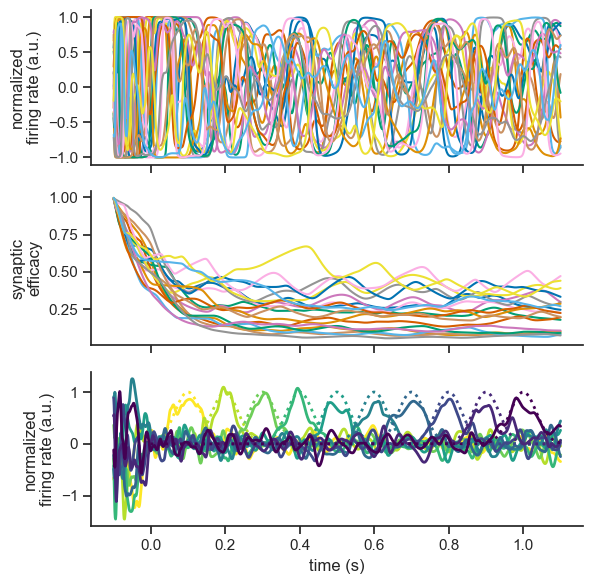

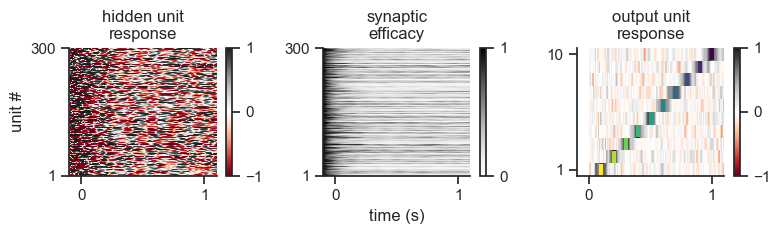

In [5]:
dt = times[1] - times[0]
model.eval()

with torch.no_grad():

    # Compute prediction error
    outputs, h_t, r_t, u_t = model(inputs, h_0=h_0, r_0=r_0, u_0=u_0, dt=dt)
    loss = loss_fn(outputs[:, times > 0, :], targets[:, times > 0, :])

# select first batch if more than one exists
hidden_batch = torch.tanh(h_t).cpu()[0]
syn_eff_batch = r_t.cpu()[0] * u_t.cpu()[0]
outputs_batch = outputs.cpu()[0]
targets_batch = targets.cpu()[0]

fig_traj = plot_state_traj(h_units=hidden_batch, outputs=outputs_batch,
                           syn_eff=syn_eff_batch,
                           targets=targets_batch, times=times)

fig_all_units = plot_all_units(h_units=hidden_batch, syn_eff=syn_eff_batch,
                               outputs=outputs_batch,
                               targets=targets_batch, times=times)

plt.show()

In [6]:
fig_traj.savefig('/home/ryan/Desktop/traj_hz_nonforce.png')
fig_all_units.savefig('/home/ryan/Desktop/units_all_hz_nonforce.png')

/tmp/ipykernel_82976/815823488.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


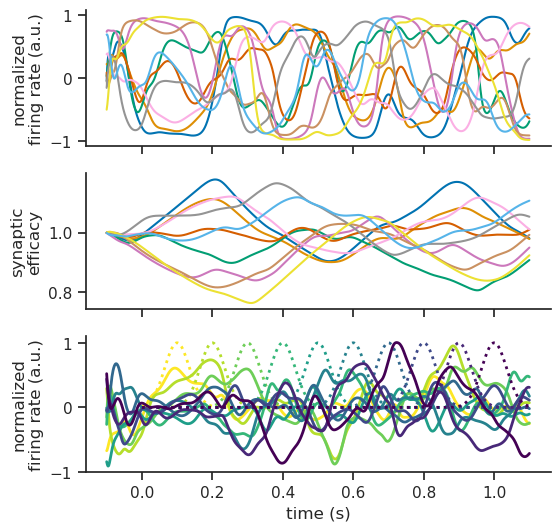

In [ ]:
dt = times[1] - times[0]
model.eval()

with torch.no_grad():

    # Compute prediction error
    outputs, h_t, u_t = model(inputs, h_0=h_0, dt=dt)
    loss = loss_fn(outputs[:, times > 0, :], targets[:, times > 0, :])

# select first batch if more than one exists
hidden_batch = torch.tanh(h_t).cpu()[0]
syn_util_batch = u_t.cpu()[0]
outputs_batch = outputs.cpu()[0]
targets_batch = targets.cpu()[0]

fig = plot_state_traj(h_units=hidden_batch, outputs=outputs_batch,
                      targets=targets_batch, times=times, syn_util=syn_util_batch)
fig.show()